# StyleGAN-NADA Inference


## Loading model and enviroment

Before start do not forget to choose gpu runtime (Runtime -> Change runtime type -> T4 GPU)

In [1]:
# Установка необходимых библиотек

# Установка зависимостей
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Установка дополнительных библиотек
!pip install Ninja

# Импорт нужных библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-imuxqs1v
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-imuxqs1v
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Клонирование репозитория StyleGAN2
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 30.79 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [3]:
import os
os.mkdir('/content/downloads')

In [4]:
cd /content/downloads/

/content/downloads


In [5]:
# Будем работать с конкретным сидом
torch.manual_seed(3456)

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights for Elf,Mona_lisa, Pixar, Sketch, Witcher, e4e, psp
ids = ['1Atj6cvvOtYEE5GyWarbxFUPsuwlUrhr_', '13qexs1zY0k4b-iB0EXqQwviXXSKPqbhi', '1_Jeb8NqfD0-vehOFkWKRhcBRlaTXlKWh', '1tjmw7H94ftX6pnJFDLjGmpzdND0bZCEw', '1MdwZcWR8dL3LpyLHMAo4CTFiELmUX_Sd', '1ZDCOR9obvIRxvNQCYX0JQWTNGfkTLZS-', '1zLSZ6Rz83AwMvBVJvIWoBxYMcolA_zGc']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [8]:

!pwd # Показывает текущую рабочую директорию


/content/downloads


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
cd /content/stylegan2-pytorch/

/content/stylegan2-pytorch


In [11]:
from model import Generator
def load_model(model_path, latent_dim, device, is_frozen = True):
  G_train = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)
  state_dict = torch.load(model_path, map_location=device)
  G_train.load_state_dict(state_dict['g_ema'] if is_frozen else state_dict)
  G_train.eval()
  print(f"Генератор в {model_path} загружен.")
  return G_train

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [12]:
# Загрузка модели генератора StyleGAN2 Elf
latent_dim = 512
G_train_Elf = load_model('/content/downloads/G_train_final_Elf.pth', latent_dim, device, False)
G_train_Mona_Lisa_Painting = load_model('/content/downloads/G_train_final_Mona_Lisa_Painting.pth', latent_dim, device, False)
G_train_Pixar = load_model('/content/downloads/G_train_final_Pixar.pth', latent_dim, device, False)
G_train_Sketch = load_model('/content/downloads/G_train_final_Sketch.pth', latent_dim, device, False)
G_train_Witcher = load_model('/content/downloads/G_train_final_Witcher.pth', latent_dim, device, False)
G_frozen = load_model('/content/downloads/stylegan2-ffhq-config-f.pt', latent_dim, device)

Генератор в /content/downloads/G_train_final_Elf.pth загружен.
Генератор в /content/downloads/G_train_final_Mona_Lisa_Painting.pth загружен.
Генератор в /content/downloads/G_train_final_Pixar.pth загружен.
Генератор в /content/downloads/G_train_final_Sketch.pth загружен.
Генератор в /content/downloads/G_train_final_Witcher.pth загружен.
Генератор в /content/downloads/stylegan2-ffhq-config-f.pt загружен.


## Inference for random generated image

In [15]:
def latent_creation(generator, num_conv = 18):
  latent_z = torch.randn(10000, 512, device=device) # Z noise
  latent_z_generated = latent_z.mean(0, keepdim=True)
  with torch.no_grad():
    latent_w = generator.style(latent_z_generated)
  initial_w_plus = latent_w.unsqueeze(1).repeat(1, num_conv, 1)
  latent = initial_w_plus.detach().clone()
  return latent

In [16]:
modification = 'Witcher' #@param['Witcher', 'Elf', 'Pixar', 'Sketch', 'Mona_Lisa_Painitng']

In [17]:
G_train = G_train_Witcher if modification == 'Witcher' else G_train_Elf if modification == 'Elf' else G_train_Pixar if modification == 'Pixar' else G_train_Sketch if modification == 'Sketch' else G_train_Mona_Lisa_Painting

/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu124. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


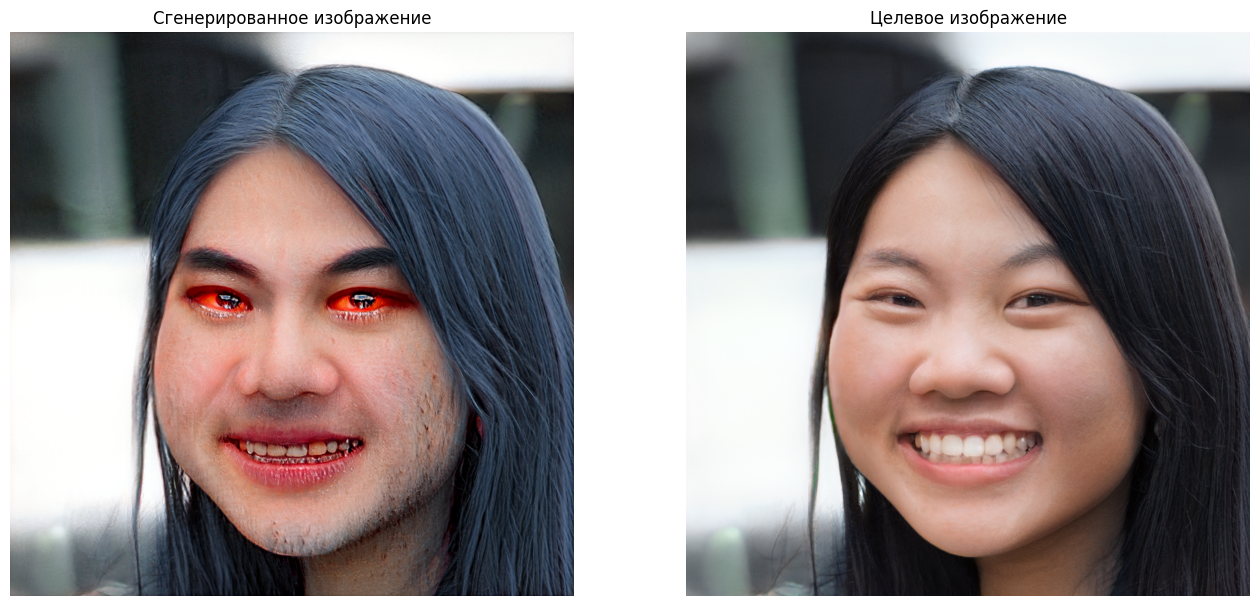

In [19]:
G_train.eval()
latent = latent_creation(G_frozen)
latent.requires_grad = False
with torch.no_grad(): # G_frozen не обучается
  image_source, _ = G_frozen([latent], input_is_latent=True, randomize_noise=False)
  image_target, _ = G_train([latent], input_is_latent=True, randomize_noise=False)
fig, axs = plt.subplots(1, 2, figsize=(16, 32))  # Создание подграфиков для визуализации
img_gen = image_target
# Визуализация сгенерированного изображения
axs[0].imshow((img_gen.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
axs[0].set_title("Сгенерированное изображение")  # Заголовок для сгенерированного изображения
axs[0].axis('off')  # Отключение осей
# Визуализация целевого изображения
axs[1].imshow((image_source.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
axs[1].set_title("Целевое изображение")  # Заголовок для целевого изображения
axs[1].axis('off')  # Отключение осей
plt.show()

## Loading e4e


In [20]:
import os
os.chdir('/content')
CODE_DIR = 'restyle_encoder'

In [21]:
!git clone https://github.com/yuval-alaluf/restyle-encoder.git $CODE_DIR

Cloning into 'restyle_encoder'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 330 (delta 0), reused 3 (delta 0), pack-reused 326 (from 1)
Receiving objects: 100% (330/330), 28.12 MiB | 46.37 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [22]:
os.chdir('/content/restyle_encoder')

In [23]:
from argparse import Namespace
import time
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp
from models.e4e import e4e

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [24]:
sys.path.append('/content/restyle_encoder/')

In [25]:
from utils.common import tensor2im
from models.psp import pSp
from models.e4e import e4e

In [26]:
encoder_type = 'psp' #@param['psp', 'e4e']

In [27]:
restyle_experiment_args = {
    "model_path": '/content/downloads/restyle_e4e_ffhq_encode.pt' if encoder_type == 'e4e' else '/content/downloads/restyle_psp_ffhq_encode.pt',
    "transform": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}

model_path = restyle_experiment_args['model_path']
ckpt = torch.load(model_path, map_location='cpu', weights_only=False)

opts = ckpt['opts']

opts['checkpoint_path'] = model_path
opts = Namespace(**opts)

restyle_net = (pSp if encoder_type == 'psp' else e4e)(opts)

restyle_net.eval()
restyle_net.cuda()
print('Model successfully loaded!')

Loading ReStyle pSp from checkpoint: /content/downloads/restyle_psp_ffhq_encode.pt
Model successfully loaded!


## Getting latent code from real image and inference for real image


Done.
Aligned image has shape: (256, 256)


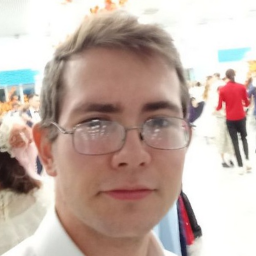

In [28]:
from utils.inference_utils import run_on_batch
import dlib
from scripts.align_faces_parallel import align_face

def run_alignment(image_path):
    if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
        print('Downloading files for aligning face image...')
        os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
        os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')
        print('Done.')
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    if aligned_image.mode == 'RGBA':
        aligned_image = aligned_image.convert('RGB')
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

def get_avg_image(net):
  avg_image = net(net.latent_avg.unsqueeze(0),
                            input_code=True,
                            randomize_noise=False,
                            return_latents=False,
                            average_code=True)[0]
  avg_image = avg_image.to('cuda').float().detach()
  return avg_image


image_path = '/content/Valya.jpg' #@param {'type': 'string'}
original_image = Image.open(image_path).convert("RGB")

input_image = run_alignment(image_path)

display(input_image)

img_transforms = restyle_experiment_args['transform']
transformed_image = img_transforms(input_image)

opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution


with torch.no_grad():
  avg_image = get_avg_image(restyle_net)
  result_batch, result_latents = run_on_batch(transformed_image.unsqueeze(0).cuda(), restyle_net, opts, avg_image)

/content/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu124. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


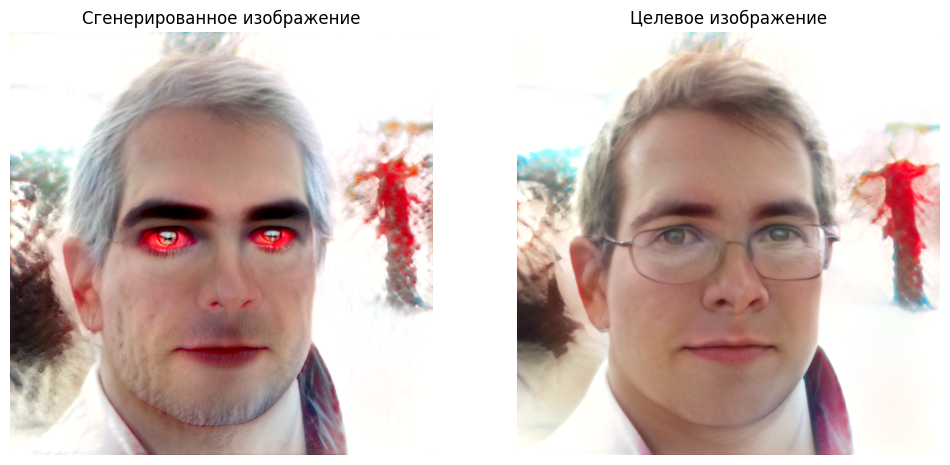

<Figure size 640x480 with 0 Axes>

In [29]:
inverted_latent = torch.Tensor(result_latents[0][4]).cuda().unsqueeze(0).unsqueeze(1)
inv_latent =  inverted_latent.squeeze(1)
inv_latent.shape
G_train.eval()
with torch.no_grad():
  real_img_style, _ = G_train([inv_latent], input_is_latent=True, randomize_noise=False)
  real_img, _ = G_frozen([inv_latent], input_is_latent=True, randomize_noise=False)
img_gen = real_img_style
target_img = real_img
# Если вы хотите несколько графиков рядом (как для сгенерированного и целевого изображения):
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # 1 строка, 2 столбца

# Ваша визуализация сгенерированного изображения
img_gen_display = (img_gen.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2
axs[0].imshow(img_gen_display) # Используйте axs напрямую, если он один, или axs[0] если массив
axs[0].set_title("Сгенерированное изображение")
axs[0].axis('off')

# Визуализация целевого изображения
axs[1].imshow((target_img.cpu().detach()[0].clip(-1,1).permute(1, 2, 0) + 1) / 2)
axs[1].set_title("Целевое изображение")  # Заголовок для целевого изображения
axs[1].axis('off')  # Отключение осей
plt.show()

plt.tight_layout() # Автоматически подстраивает расположение сублотов
plt.show() # Важно вызвать plt.show()